#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

## Predicting firm exit

In [6]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

## Import data

In [7]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv("/workspaces/codespaces-jupyter/data/bisnode_firms_clean3.csv")

In [8]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,17367.0,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,1.736700e+04,...,17367.000000,17367.000000,17367.000000,17367.000000,17367.000000,1.736700e+04,17367.000000,17367.000000,17367.000000,17367.000000
mean,2010.0,1.534101e+11,9.387459e+03,9.210775e+04,8.339543e+04,7.899953e+02,2.218524e+03,1.429042e+03,1.482772e+05,3.469260e+03,...,0.002073,0.243047,0.240686,0.687059,0.162722,1.212369e+01,0.033166,0.023838,-0.045062,0.276069
std,0.0,1.378409e+11,4.765598e+04,4.384136e+05,5.105341e+05,2.792942e+04,5.088487e+04,5.441710e+04,1.184102e+06,2.818630e+05,...,0.045483,0.428936,0.427513,1.662832,0.369123,1.021040e+01,0.179076,0.152550,0.523502,0.586535
min,2010.0,1.001034e+06,-5.150741e+04,0.000000e+00,-4.270371e+03,-3.148148e+02,-7.111111e+02,-2.597422e+06,0.000000e+00,-1.835527e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,9.990009e-07,0.000000,0.000000,-1.500000,0.000000
25%,2010.0,2.837590e+10,1.777778e+02,3.322222e+03,3.329630e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.592592e+02,-5.694445e+03,...,0.000000,0.000000,0.000000,0.145833,0.000000,4.217157e+00,0.000000,0.000000,-0.197594,0.000409
50%,2010.0,1.145027e+11,1.066667e+03,1.112593e+04,1.340741e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.433333e+03,2.370370e+02,...,0.000000,0.000000,0.000000,0.333333,0.000000,9.647505e+00,0.000000,0.000000,0.000000,0.022823
75%,2010.0,2.575038e+11,4.522222e+03,3.846296e+04,4.533148e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.199259e+04,3.518519e+03,...,0.000000,0.000000,0.000000,0.681054,0.000000,1.727416e+01,0.000000,0.000000,0.105637,0.176670
max,2010.0,4.641050e+11,2.708996e+06,2.818923e+07,4.240263e+07,2.822648e+06,5.658556e+06,5.424026e+06,9.401226e+07,2.943638e+07,...,1.000000,1.000000,1.000000,51.958332,1.000000,4.766602e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [9]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


In [10]:
import seaborn as sns

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label="ROC Curve")
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random Guess")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    plt.figure(figsize=(8, 6))
    sns.lineplot(x="thresholds", y="loss", data=all_coords_copy, color="blue")
    plt.axvline(x=optimal_threshold, color="red", linestyle="--", label="Optimal Threshold")
    plt.text(
        optimal_threshold - 0.01,
        max(all_coords_copy["loss"]) - 0.4,
        f"Best Threshold: {round(optimal_threshold, 2)}",
        rotation=90,
        color="red",
    )
    plt.text(optimal_threshold + 0.06, curr_exp_loss, f"{round(curr_exp_loss, 2)}", color="green")
    plt.xlabel("Thresholds")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.legend()
    plt.grid(True)
    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plt.figure(figsize=(8, 6))
    sns.lineplot(x="sp", y="se", data=all_coords_copy, color="blue", label="ROC Curve")
    plt.scatter([sp], [se], color="red", label=f"Optimal Point ({round(sp, 2)}, {round(se, 2)})")
    plt.fill_between(all_coords_copy["sp"], all_coords_copy["se"], alpha=0.3, color="mediumaquamarine")
    plt.plot([0, 1], [0, 1], linestyle="--", color="green", label="Random Guess")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC Curve with Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model building

### Define variable sets 

### Key financial metrics

In [11]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

### List of variables related to the quality of financial statements or balance sheets:

In [12]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

###  List of engineered financial variables that represent normalized financial metrics:

In [13]:

engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]


### Engineered variables that represent quadratic terms of certain financial ratios:


In [14]:
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

### Flag variables

In [15]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

### Growth variables

In [16]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

### Human capital related variables

In [17]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

### Firms history related variables

In [18]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [19]:
data["m_region_loc"].value_counts()

m_region_loc
Central    10252
East        4435
West        2680
Name: count, dtype: int64

In [20]:
firm

['age', 'age2', 'new', 'C(ind2_cat)', 'C(m_region_loc)', 'C(urban_m)']

interactions for logit, LASSO

In [60]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [22]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1

M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

In [23]:
M2

['sales_mil_log',
 'sales_mil_log_sq',
 'd1_sales_mil_log_mod',
 'profit_loss_year_pl',
 'fixed_assets_bs',
 'share_eq_bs',
 'curr_liab_bs ',
 'curr_liab_bs_flag_high ',
 'curr_liab_bs_flag_error',
 'age',
 'foreign_management',
 'C(ind2_cat)']

2. logit+LASSO

In [61]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [25]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [26]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:38:54   Log-Likelihood:                -7715.7
No. Observations:               17367   AIC:                         1.547e+04
Df Residuals:                   17348   BIC:                         1.562e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1762      0.015     11.758      0.000       0.147       0.206
C(ind2_cat)[T.27.0]         0.0004      0.016      0.024      0.981      -0.031       0.031
C(ind2_cat)[T.28.0]         0.0106      0.012      0.878      0.380      -0.013       0.034
C(ind2_cat)[T.29.0]         0.0129      0.022      0.585      0.559      -0.030       0.056
C(ind2_cat)[T.30.0]        -0.0318      0.026     -1.236      0.217      -0.082       0.019
C(ind2_cat)[T.33.0]        -0.0297      0.012     -2.405      0.016      -0.054      -0.005
C(ind2_cat)[T.55.0]         0.0244      0.013      1.821      0.069      -0.002       0.051
C(ind2_cat)[T.56.0]         0.0657      0.011      5.930      0.000       0.044       0.087
sales_mil_log               0.0121      0.004      3.050      0.002       0.004       0.020
sales_mil_log_sq            0.0071      0.001      9.715      0.000       0.006       0.009
d1_sales_mil_log_mod       -0.0537      0.007     -8.027      0.000      -0.067      -0.041
profit_loss_year_pl        -0.0865      0.012     -7.114      0.000      -0.110      -0.063
fixed_assets_bs            -0.1246      0.010    -12.752      0.000      -0.144      -0.105
share_eq_bs                -0.0460      0.008     -6.048      0.000      -0.061      -0.031
curr_liab_bs                0.0298      0.013      2.327      0.020       0.005       0.055
curr_liab_bs_flag_high      0.0397      0.012      3.285      0.001       0.016       0.063
curr_liab_bs_flag_error     0.3781      0.170      2.219      0.026       0.044       0.712
age                        -0.0066      0.000    -13.474      0.000      -0.008      -0.006
foreign_management          0.0606      0.010      5.930      0.000       0.041       0.081
==============================================================================
Omnibus:                     2488.444   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3744.864
Skew:                           1.136   Prob(JB):                         0.00
Kurtosis:                       3.114   Cond. No.                         875.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [27]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:38:54   Log-Likelihood:                -7715.7
No. Observations:               17367   AIC:                         1.547e+04
Df Residuals:                   17348   BIC:                         1.562e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1762      0.015     11.758      0.000       0.147       0.206
C(ind2_cat)[T.27.0]         0.0004      0.016      0.024      0.981      -0.031       0.031
C(ind2_cat)[T.28.0]         0.0106      0.012      0.878      0.380      -0.013       0.034
C(ind2_cat)[T.29.0]         0.0129      0.022      0.585      0.559      -0.030       0.056
C(ind2_cat)[T.30.0]        -0.0318      0.026     -1.236      0.217      -0.082       0.019
C(ind2_cat)[T.33.0]        -0.0297      0.012     -2.405      0.016      -0.054      -0.005
C(ind2_cat)[T.55.0]         0.0244      0.013      1.821      0.069      -0.002       0.051
C(ind2_cat)[T.56.0]         0.0657      0.011      5.930      0.000       0.044       0.087
sales_mil_log               0.0121      0.004      3.050      0.002       0.004       0.020
sales_mil_log_sq            0.0071      0.001      9.715      0.000       0.006       0.009
d1_sales_mil_log_mod       -0.0537      0.007     -8.027      0.000      -0.067      -0.041
profit_loss_year_pl        -0.0865      0.012     -7.114      0.000      -0.110      -0.063
fixed_assets_bs            -0.1246      0.010    -12.752      0.000      -0.144      -0.105
share_eq_bs                -0.0460      0.008     -6.048      0.000      -0.061      -0.031
curr_liab_bs                0.0298      0.013      2.327      0.020       0.005       0.055
curr_liab_bs_flag_high      0.0397      0.012      3.285      0.001       0.016       0.063
curr_liab_bs_flag_error     0.3781      0.170      2.219      0.026       0.044       0.712
age                        -0.0066      0.000    -13.474      0.000      -0.008      -0.006
foreign_management          0.0606      0.010      5.930      0.000       0.041       0.081
==============================================================================
Omnibus:                     2488.444   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3744.864
Skew:                           1.136   Prob(JB):                         0.00
Kurtosis:                       3.114   Cond. No.                         875.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [28]:
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.441991
         Iterations 7


With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [29]:
# Define and fit the logit model
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

# Calculate and display marginal effects
logit_modelx2.get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.441991
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]        -0.0024      0.025     -0.099      0.921      -0.051       0.046
C(ind2_cat)[T.28.0]         0.0129      0.018      0.706      0.480      -0.023       0.049
C(ind2_cat)[T.29.0]         0.0180      0.033      0.549      0.583      -0.046       0.082
C(ind2_cat)[T.30.0]        -0.0424      0.043     -0.978      0.328      -0.127       0.043
C(ind2_cat)[T.33.0]        -0.0410      0.019     -2.126      0.034      -0.079      -0.003
C(ind2_cat)[T.55.0]         0.0271      0.018      1.520      0.129      -0.008       0.062
C(ind2_cat)[T.56.0]         0.0698      0.015      4.551      0.000       0.040       0.100
sales_mil_log              -0.0056      0.006     -0.974      0.330      -0.017       0.006
sales_mil_log_sq            0.0041      0.001      4.953      0.000       0.002       0.006
d1_sales_mil_log_mod       -0.0538      0.006     -9.523      0.000      -0.065      -0.043
profit_loss_year_pl        -0.0502      0.009     -5.596      0.000      -0.068      -0.033
fixed_assets_bs            -0.1124      0.009    -12.353      0.000      -0.130      -0.095
share_eq_bs                -0.0453      0.007     -6.886      0.000      -0.058      -0.032
curr_liab_bs                0.0509      0.013      4.005      0.000       0.026       0.076
curr_liab_bs_flag_high      0.0075      0.011      0.711      0.477      -0.013       0.028
curr_liab_bs_flag_error     0.2880      0.115      2.511      0.012       0.063       0.513
age                        -0.0071      0.001    -13.758      0.000      -0.008      -0.006
foreign_management          0.0669      0.009      7.202      0.000       0.049       0.085
===========================================================================================
"""

## 0. Separate train and holdout data

In [30]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [31]:
print("Total")
print(data["default"].value_counts(normalize=True))
print("Train")
print(data_train["default"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["default"].value_counts(normalize=True))


Total
default
0    0.790407
1    0.209593
Name: proportion, dtype: float64
Train
default
0    0.791118
1    0.208882
Name: proportion, dtype: float64
Holdout
default
0    0.787565
1    0.212435
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [32]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [33]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [34]:
C_value_logit = [1e20]

In [51]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [49]:
c_value_logit = [1e20]
logit_models = dict()
cv_brier_scores = dict()

for i, model_vars in enumerate(logit_model_vars):
    model_equation = "default ~ " + " + ".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=c_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    model_name = "M" + str(i + 1)
    logit_models[model_name] = LRCV_brier.fit(X_train, y_train)

    # Brier score is negative, so take the negative of the mean to get actual Brier score
    mean_brier = -np.mean(logit_models[model_name].scores_[1].ravel())
    cv_brier_scores[model_name] = mean_brier

# Convert to DataFrame
cv_brier_df = pd.DataFrame.from_dict(cv_brier_scores, orient="index", columns=["Mean_Brier_Score"])

# Sort to get the best model
cv_brier_df = cv_brier_df.sort_values("Mean_Brier_Score")

# Show results
print(cv_brier_df)

# Best model
best_model_name = cv_brier_df.index[0]
best_model = logit_models[best_model_name]
print(f"\n✅ Best model: {best_model_name} with Brier score = {cv_brier_df.loc[best_model_name, 'Mean_Brier_Score']:.4f}")

    Mean_Brier_Score
M5          0.131607
M4          0.131976
M3          0.139971
M2          0.141981
M1          0.148982

✅ Best model: M5 with Brier score = 0.1316


In [54]:
print(cv_brier_df)

    Mean_Brier_Score
M5          0.131607
M4          0.131976
M3          0.139971
M2          0.141981
M1          0.148982


In [53]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.385659,0.376238,0.374330,0.362779,0.361762
1,0.390987,0.381321,0.380832,0.369590,0.368371
2,0.388984,0.379594,0.376073,0.366664,0.367327
3,0.376381,0.370204,0.365674,0.356385,0.356660
4,0.387729,0.376566,0.373566,0.360860,0.359626


### b) Logit + LASSO

In [55]:
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [56]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

![alt text](image.png)

Set regularization parameters

In [57]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [63]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [64]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
#cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso["brier_score"] = cv_summary_lasso["mean_cv_score"] * -1
cv_summary_lasso

#with normalization

,lambdas,C_values,mean_cv_score,brier_score
0,0.100000,0.000900,-0.173152,0.173152
1,0.046416,0.001938,-0.144453,0.144453
2,0.021544,0.004176,-0.134908,0.134908
3,0.010000,0.008997,-0.132021,0.132021
4,0.004642,0.019384,-0.131214,0.131214
5,0.002154,0.041762,-0.131155,0.131155
6,0.001000,0.089973,-0.131261,0.131261
7,0.000464,0.193842,-0.131519,0.131519
8,0.000215,0.417619,-0.131742,0.131742
9,0.000100,0.899734,-0.131925,0.131925


Save best lambda's index for later use

In [70]:
cv_summary_lasso["brier_score"].idxmin()

5

In [67]:
best_lambda_i = cv_summary_lasso["brier_score"].idxmin()

In [44]:
# lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))

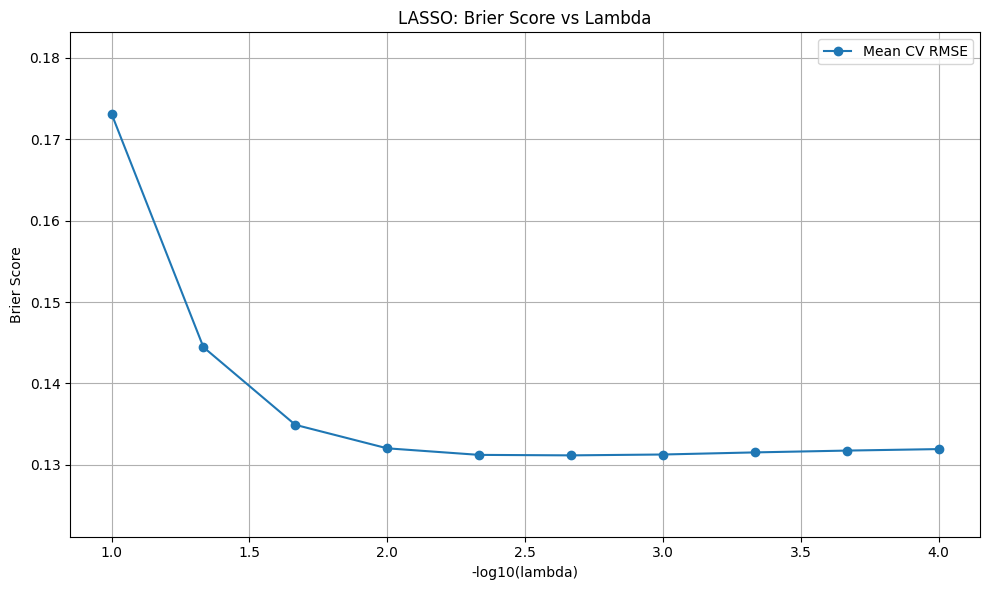

In [73]:
# Plot lambdas vs mean CV RMSE with zoomed-in Y-axis
plt.figure(figsize=(10, 6))
plt.plot(-np.log10(lambdas), cv_summary_lasso["brier_score"], marker='o', label="Mean CV RMSE")
plt.xlabel("-log10(lambda)")
plt.ylabel("Brier Score")
plt.title("LASSO: Brier Score vs Lambda")
plt.ylim(cv_summary_lasso["brier_score"].min() - 0.01, cv_summary_lasso["brier_score"].max() + 0.01)  # Adjust Y-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Extract CV test RMSE for the Lasso with best lambda

In [74]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [75]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [76]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [77]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

### LASSO-selected Features

In [78]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

73

In [79]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

73

In [80]:
# Extract the coefficients and feature names
lasso_model = logit_models["LASSO"]  # Get the LASSO model
coefficients = lasso_model.coef_[0]  # Coefficients for the LASSO model
feature_names = normalized_logitvars.columns  # Feature names from normalized data


lasso_selected_features = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).query("Coefficient != 0")  # Filter only non-zero coefficients

lasso_selected_features = lasso_selected_features.sort_values(by="Coefficient", ascending=False)
print(lasso_selected_features)

                     Feature  Coefficient
109        flag_miss_ceo_age     0.522167
88   d1_sales_mil_log_mod_sq     0.308921
7        C(ind2_cat)[T.56.0]     0.266867
51       inc_bef_tax_pl_quad     0.154102
144                      new     0.147795
..                       ...          ...
46            inventories_pl    -0.134087
80      d1_sales_mil_log_mod    -0.155363
39               share_eq_bs    -0.174598
36           fixed_assets_bs    -0.206280
128                      age    -0.310427

[73 rows x 2 columns]


In [83]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.385948,0.710298
M2,19,0.376784,0.755016
M3,36,0.374095,0.766460
M4,78,0.363256,0.795626
M5,152,0.362749,0.796378
LASSO,73,0.362123,0.712065


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [84]:
best_logit = logit_models["M4"]
model_equation = "default~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [85]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["default"]), 3)

np.float64(0.365)

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


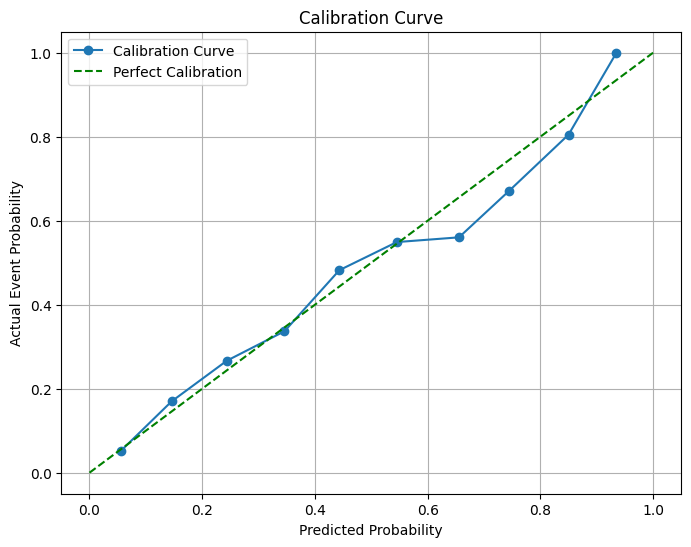

In [86]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    data_holdout["default"], data_holdout["best_logit_pred_proba"], n_bins=10
)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="green", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Event Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()


### b) Confusion table with different tresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

In [87]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  3133
1.0  (default):  341


In [88]:
X_holdout

DesignMatrix with shape (3474, 78)
  Columns:
    ['Intercept',
     'C(ind2_cat)[T.27.0]',
     'C(ind2_cat)[T.28.0]',
     'C(ind2_cat)[T.29.0]',
     'C(ind2_cat)[T.30.0]',
     'C(ind2_cat)[T.33.0]',
     'C(ind2_cat)[T.55.0]',
     'C(ind2_cat)[T.56.0]',
     'C(m_region_loc)[T.East]',
     'C(m_region_loc)[T.West]',
     'C(urban_m)[T.2.0]',
     'C(urban_m)[T.3.0]',
     'sales_mil_log',
     'sales_mil_log_sq',
     'age',
     'age2',
     'new',
     'total_assets_bs',
     'fixed_assets_bs',
     'liq_assets_bs',
     'curr_assets_bs',
     'share_eq_bs',
     'subscribed_cap_bs',
     'intang_assets_bs',
     'extra_exp_pl',
     'extra_inc_pl',
     'extra_profit_loss_pl',
     'inc_bef_tax_pl',
     'inventories_pl',
     'material_exp_pl',
     'profit_loss_year_pl',
     'personnel_exp_pl',
     'extra_profit_loss_pl_quad',
     'inc_bef_tax_pl_quad',
     'profit_loss_year_pl_quad',
     'share_eq_bs_quad',
     'extra_exp_pl_flag_high',
     'extra_inc_pl_flag_high',


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [89]:
cm_object1 = confusion_matrix(
    data_holdout["default"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1

,Predicted no default,Predicted default
Actul no defaul,2608,128
Actual default,525,213


In [90]:
data_holdout

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,best_logit_pred_proba
7221,2010,7.951208e+10,2010-01-01,2010-12-31,577.777771,2.256667e+04,1237.036987,0.000000,0.0,0.000000,...,0,0.681054,1,no_default,14.961471,0,0,-0.767078,0.588409,0.106639
6377,2010,6.151970e+10,2010-01-01,2010-12-31,3459.259277,2.062593e+04,433881.468750,74.074074,0.0,-74.074074,...,0,0.666667,0,no_default,3.684643,0,0,0.108699,0.011816,0.179377
4724,2010,3.369987e+10,2010-01-01,2010-12-31,33270.371094,1.570852e+05,70666.664062,0.000000,0.0,0.000000,...,0,1.062500,0,no_default,0.250277,0,0,-0.160854,0.025874,0.022691
12544,2010,2.384612e+11,2010-01-01,2010-12-31,1918.518555,9.703704e+02,8211.111328,0.000000,0.0,0.000000,...,0,0.083333,0,no_default,24.056817,0,0,-0.134031,0.017964,0.148898
7975,2010,9.663108e+10,2010-01-01,2010-12-31,14185.185547,2.447407e+04,70966.664062,0.000000,0.0,0.000000,...,0,0.802083,0,no_default,3.129201,0,0,-0.149149,0.022245,0.067862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14166,2010,3.060631e+11,2010-01-01,2010-12-31,0.000000,4.655556e+03,39385.183594,0.000000,0.0,0.000000,...,1,0.312500,0,default,21.679022,0,0,-1.306836,1.707820,0.674161
399,2010,2.484187e+08,2010-01-01,2010-12-31,6418.518555,3.890741e+04,30325.925781,0.000000,0.0,0.000000,...,0,0.229167,0,no_default,11.657326,0,0,0.000000,0.000000,0.150182
14015,2010,2.998379e+11,2010-01-01,2010-12-31,73585.187500,2.263548e+06,945537.062500,0.000000,0.0,0.000000,...,0,3.625000,0,no_default,1.866570,0,0,-0.151745,0.023027,0.032910
8409,2010,1.071768e+11,2010-01-01,2010-12-31,1677.777832,7.037037e+03,31555.554688,0.000000,0.0,0.000000,...,1,0.333333,0,no_default,9.973450,0,0,0.000000,0.000000,0.219075


In [91]:
data_holdout.shape

(3474, 117)

### Applying Threshold

#### 1. Basic Threshold - 0.5

In [92]:
# 0.5 - basic
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)

#### Explanation of the labels:

Actual no defaul: Represents the rows in the confusion matrix where the actual value of the target variable (data_holdout["default"]) is 0 (no default) - NOT EXIT

Actual default:Represents the rows in the confusion matrix where the actual value of the target variable (data_holdout["default"]) is 1 (default) - EXIT


In [93]:
cm_object1b = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1b

,Predicted no default,Predicted default
Actul no defaul,2608,128
Actual default,525,213


In [94]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for the basic threshold (0.5)
accuracy_basic = accuracy_score(data_holdout["default"], holdout_prediction)
print(f"Accuracy with threshold 0.5: {accuracy_basic:.3f}")

Accuracy with threshold 0.5: 0.812


#### 2. A sensible choice: mean of predicted probabilities 

In [95]:
# this is another way to intiate a threshold - based on mean across all predictions fro holdout set
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

np.float64(0.208)

In [96]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)

In [97]:
cm_object2 = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm2

,Predicted no default,Predicted default
Actul no defaul,2032,704
Actual default,225,513


In [98]:
accuracy_mean = accuracy_score(data_holdout["default"], holdout_prediction)
print(f"Accuracy with mean predicted probability threshold: {accuracy_mean:.3f}")

Accuracy with mean predicted probability threshold: 0.733


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [99]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["default"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [100]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

In [101]:
tpr_fpr_for_thresholds 

,thresholds,true_positive_rates,false_positive_rates
0,0.05,0.975610,0.794225
1,0.10,0.905149,0.533626
2,0.15,0.810298,0.376827
3,0.20,0.705962,0.270833
4,0.25,0.631436,0.193713
5,0.30,0.547425,0.153143
6,0.35,0.474255,0.114766
7,0.40,0.417344,0.084064
8,0.45,0.341463,0.059942
9,0.50,0.288618,0.046784


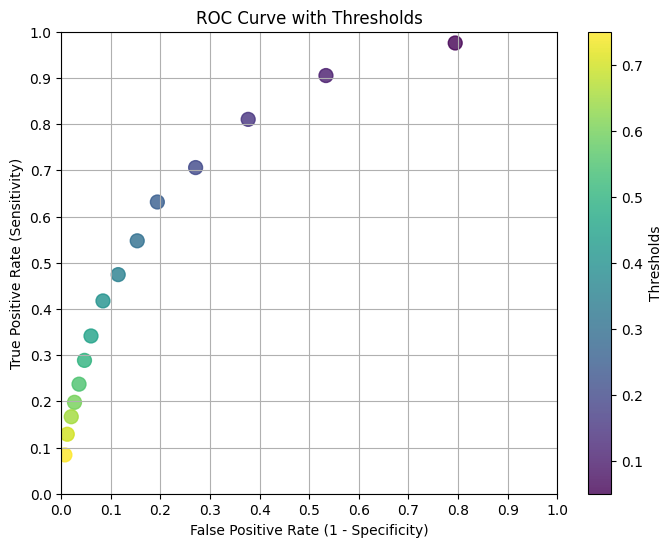

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Plot ROC curve with thresholds
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    tpr_fpr_for_thresholds["false_positive_rates"],
    tpr_fpr_for_thresholds["true_positive_rates"],
    c=tpr_fpr_for_thresholds["thresholds"],
    cmap="viridis",
    s=100,
    alpha=0.8,
)
plt.colorbar(scatter, label="Thresholds")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Thresholds")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(True)
plt.show()

Continuous ROC on holdout with best model

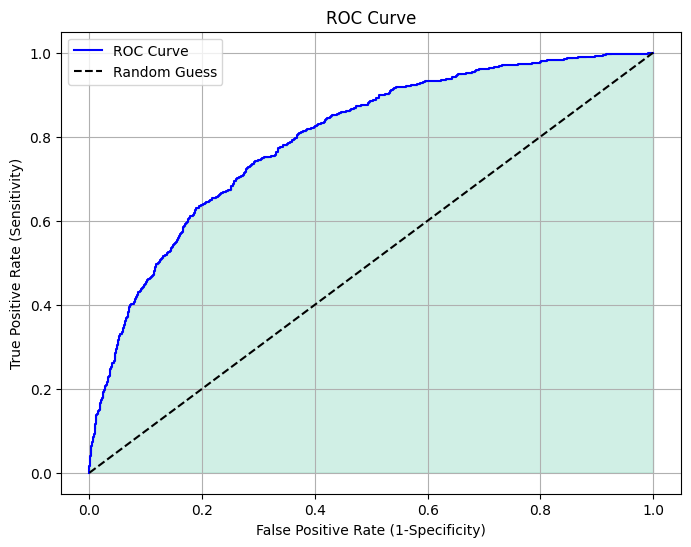

In [103]:
create_roc_plot(data_holdout["default"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [104]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [105]:
prevelance = y_train.sum() / len(y_train)
prevelance 

# the fraction of the dataset that belongs to the positive class (e.g., firms that defaulted). 
# 
# For example:
# If prevelance = 0.2, it means 20% of the firms in the training data defaulted.

array(0.20888217)

In [106]:
y_train

DesignMatrix with shape (13893, 1)
  default
        0
        1
        0
        0
        0
        0
        0
        0
        0
        0
        0
        0
        0
        1
        0
        0
        0
        0
        1
        0
        0
        0
        0
        0
        1
        0
        0
        1
        1
        0
  [13863 rows omitted]
  Terms:
    'default' (column 0)
  (to view full data, use np.asarray(this_obj))

In [107]:
y_train.sum()

array(2902.)

In [108]:
len(y_train)

13893

### Finding an optimal threshold with the formula

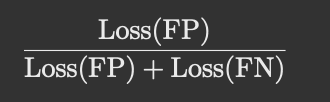

In [109]:
# Compute the threshold directly from the formula
theoretical_threshold = FP / (FP + FN)  # = 1 / (1 + 10) = 0.0909

# Store results
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    expected_losses = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i

    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]

        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )

        # Apply the theoretical threshold
        threshold_prediction = np.where(pred_fold >= theoretical_threshold, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0, 1]).ravel()
        loss = (fp * FP + fn * FN) / len(y_fold)
        expected_losses.append(loss)
        fold += 1

    best_thresholds_cv[model_name] = theoretical_threshold
    expected_loss_cv[model_name] = np.mean(expected_losses)
    fold5_threshold[model_name] = theoretical_threshold
    fold5_expected_loss[model_name] = loss  # from last fold

    # Save coordinates from ROC curve of last fold
    false_pos_rate, true_pos_rate, roc_thresholds = roc_curve(y_fold, pred_fold)
    all_coords = pd.DataFrame({
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": roc_thresholds,
    })

    fold5_all_coords[model_name] = all_coords

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [69]:
best_thresholds_cv = dict() #To store the average best threshold (cutoff) across all CV folds for each model
expected_loss_cv = dict() # To store the average expected loss across all CV folds for each model
fold5_threshold = dict() # To store the best threshold for fold #5 for each model
fold5_expected_loss = dict() # To store the expected loss for fold #5 for each model
fold5_all_coords = dict() # To store all coordinates for fold #5 for each model

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO": # for logit models only
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else: # for LASSO M5 model
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0


    
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]

        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(zip(np.abs(
                        # TPR = TP / (TP + FN);
                        true_pos_rate + 
                        # 1 - prevelance = 1 - y_train.sum() / len(y_train) ; 
                        # cost * prevalnce = FN / FP * y_train.sum() / len(y_train)
                        (1 - prevelance) / (cost * prevelance) 
                        # FPR = FP / (FP + TN)
                        * (1 - false_pos_rate)
                    ),thresholds,)
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]


        best_thresholds.append(optimal_threshold) # adding optimal/best threshold

        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()

        #Expected loss is like a "penalty score" that tells 
        # us how much we are "paying" for making mistakes in predictions.
        # FP cost = 1l FN = 10;
        # Expected loss combines these costs and divides 
        # by the total number of predictions to give an average penalty per prediction.

        # Example: 
        # You made 5 FP mistakes (cost = 1 each) → Total cost = 5.
        # You made 2 FN mistakes (cost = 10 each) → Total cost = 20.
        # Total predictions = 100. ---> Expected loss = (5 + 20) / 100 = 0.25


        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold) # expected loss 
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds) #take means as we do CV, for each model
    expected_loss_cv[model_name] = np.mean(expected_loss) #take means as we do CV, for each model

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [110]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()
summary_with_lossfnc["Avg RMSE"] = pd.DataFrame(CV_RMSE_folds).mean(axis=0).values


### Avg of optimal thresholds: 
What You’re Saying With That 0.08 Threshold:
If my model thinks there’s even an 8% chance that a company will default, 
I’d rather flag them as a risk than let them slip through — 
because missing a true default (false negative) is 10 times more costly than flagging someone who would have paid back (false positive).

### Avg Expected loss: Lower Expected Loss = Better

In [111]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5,Avg RMSE
0,M1,0.090909,0.090909,0.747501,0.765299,0.385948
1,M2,0.090909,0.090909,0.679768,0.677826,0.376784
2,M3,0.090909,0.090909,0.661844,0.656587,0.374095
3,M4,0.090909,0.090909,0.630028,0.610511,0.363256
4,M5,0.090909,0.090909,0.619807,0.597552,0.362749
5,LASSO,0.090909,0.090909,0.629740,0.604392,0.362123


Create loss plot based on Fold5 in CV 

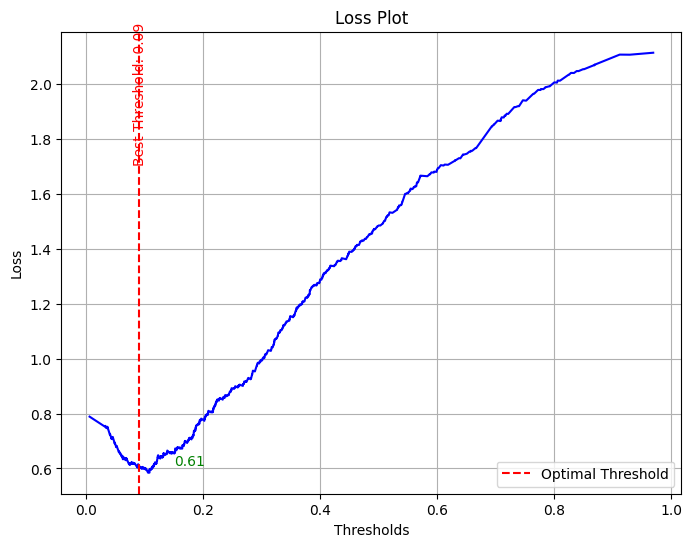

In [112]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

In [113]:
best_thresholds_cv["M4"]

0.09090909090909091

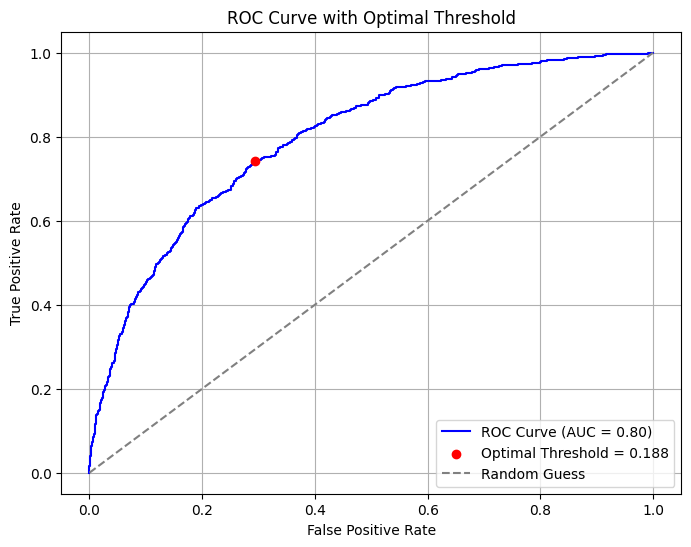

In [115]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(data_holdout["default"], data_holdout["best_logit_pred_proba"])
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}', zorder=5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [116]:
# Extract the DataFrame for the selected model
all_coords = fold5_all_coords[model_to_plot]

# Get the optimal threshold for the selected model
optimal_threshold = fold5_threshold[model_to_plot]

# Find the row where the threshold is closest to the optimal threshold
optimal_row = all_coords.iloc[(all_coords["thresholds"] - optimal_threshold).abs().idxmin()]

# Calculate FPR (False Positive Rate) and TPR (True Positive Rate)
optimal_fpr = 1 - (optimal_row["true_neg"] / optimal_row["neg"])  # FPR = 1 - Specificity
optimal_tpr = (optimal_row["true_pos"] / optimal_row["pos"])      # TPR = Sensitivity

print(f"Optimal FPR: {optimal_fpr}")
print(f"Optimal TPR: {optimal_tpr}")

Optimal FPR: 0.5933363760839799
Optimal TPR: 0.9301533219761499


Let's see our chosen model, M4's holdout expected loss

In [117]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["default"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["default"])
round(expected_loss_holdout, 3)

np.float64(0.615)

In [118]:
best_logit_optimal_treshold 

0.09090909090909091

CM on holdout

In [119]:
cm_object3 = confusion_matrix(data_holdout["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3 # optimal TR

,Predicted no default,Predicted default
Actul no defaul,1180,1556
Actual default,58,680


In [123]:
print(tp)
print(tn)
print(fn)
print(fp)

760
1268
59
1902


In [115]:
cm1 # TR = 0.5

,Predicted no default,Predicted default
Actul no defaul,3035,135
Actual default,587,232


In [116]:
cm2 # TR = mean

,Predicted no default,Predicted default
Actul no defaul,2278,892
Actual default,238,581


In [125]:
# Extract values from cm3
tn = cm3.loc["Actul no defaul", "Predicted no default"]
fp = cm3.loc["Actul no defaul", "Predicted default"]
fn = cm3.loc["Actual default", "Predicted no default"]
tp = cm3.loc["Actual default", "Predicted default"]

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
false_neg_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calculate expected loss
expected_loss = (fp * FP + fn * FN) / (tp + tn + fp + fn)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"False Negative Rate: {false_neg_rate:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"Expected Loss: {expected_loss:.3f}")

Accuracy: 0.508
Precision: 0.285
Recall (Sensitivity): 0.928
Specificity: 0.400
False Negative Rate: 0.072
F1 Score: 0.437
Expected Loss: 0.625


In [126]:

tn_cm1 = cm1.loc["Actul no defaul", "Predicted no default"]
fp_cm1 = cm1.loc["Actul no defaul", "Predicted default"]
fn_cm1 = cm1.loc["Actual default", "Predicted no default"]
tp_cm1 = cm1.loc["Actual default", "Predicted default"]

# Calculate metrics for cm1
accuracy_cm1 = (tp_cm1 + tn_cm1) / (tp_cm1 + tn_cm1 + fp_cm1 + fn_cm1)
precision_cm1 = tp_cm1 / (tp_cm1 + fp_cm1) if (tp_cm1 + fp_cm1) > 0 else 0
recall_cm1 = tp_cm1 / (tp_cm1 + fn_cm1) if (tp_cm1 + fn_cm1) > 0 else 0
specificity_cm1 = tn_cm1 / (tn_cm1 + fp_cm1) if (tn_cm1 + fp_cm1) > 0 else 0
f1_score_cm1 = 2 * (precision_cm1 * recall_cm1) / (precision_cm1 + recall_cm1) if (precision_cm1 + recall_cm1) > 0 else 0
expected_loss_cm1 = (fp_cm1 * FP + fn_cm1 * FN) / (tp_cm1 + tn_cm1 + fp_cm1 + fn_cm1)
false_neg_rate_cm1 = fn_cm1 / (fn_cm1 + tp_cm1) if (fn_cm1 + tp_cm1) > 0 else 0

# Print metrics for cm1
print("Metrics for cm1 (TR = 0.5):")
print(f"Accuracy: {accuracy_cm1:.3f}")
print(f"Precision: {precision_cm1:.3f}")
print(f"Recall (Sensitivity): {recall_cm1:.3f}")
print(f"Specificity: {specificity_cm1:.3f}")
print(f"F1 Score: {f1_score_cm1:.3f}")
print(f"Expected Loss: {expected_loss_cm1:.3f}")
print(f"False Negative Rate: {false_neg_rate_cm1:.3f}")

# Extract values from cm2 (TR = mean)
tn_cm2 = cm2.loc["Actul no defaul", "Predicted no default"]
fp_cm2 = cm2.loc["Actul no defaul", "Predicted default"]
fn_cm2 = cm2.loc["Actual default", "Predicted no default"]
tp_cm2 = cm2.loc["Actual default", "Predicted default"]

# Calculate metrics for cm2
accuracy_cm2 = (tp_cm2 + tn_cm2) / (tp_cm2 + tn_cm2 + fp_cm2 + fn_cm2)
precision_cm2 = tp_cm2 / (tp_cm2 + fp_cm2) if (tp_cm2 + fp_cm2) > 0 else 0
recall_cm2 = tp_cm2 / (tp_cm2 + fn_cm2) if (tp_cm2 + fn_cm2) > 0 else 0
specificity_cm2 = tn_cm2 / (tn_cm2 + fp_cm2) if (tn_cm2 + fp_cm2) > 0 else 0
f1_score_cm2 = 2 * (precision_cm2 * recall_cm2) / (precision_cm2 + recall_cm2) if (precision_cm2 + recall_cm2) > 0 else 0
expected_loss_cm2 = (fp_cm2 * FP + fn_cm2 * FN) / (tp_cm2 + tn_cm2 + fp_cm2 + fn_cm2)
false_neg_rate_cm2 = fn_cm2 / (fn_cm2 + tp_cm2) if (fn_cm2 + tp_cm2) > 0 else 0

# Print metrics for cm2
print("\nMetrics for cm2 (TR = mean):")
print(f"Accuracy: {accuracy_cm2:.3f}")
print(f"Precision: {precision_cm2:.3f}")
print(f"Recall (Sensitivity): {recall_cm2:.3f}")
print(f"Specificity: {specificity_cm2:.3f}")
print(f"F1 Score: {f1_score_cm2:.3f}")
print(f"Expected Loss: {expected_loss_cm2:.3f}")
print(f"False Negative Rate: {false_neg_rate_cm2:.3f}")

# Extract values from cm3
tn_cm3 = cm3.loc["Actul no defaul", "Predicted no default"]
fp_cm3 = cm3.loc["Actul no defaul", "Predicted default"]
fn_cm3 = cm3.loc["Actual default", "Predicted no default"]
tp_cm3 = cm3.loc["Actual default", "Predicted default"]


# Calculate metrics
accuracy_cm3 = (tp_cm3 + tn_cm3) / (tp_cm3 + tn_cm3 + fp_cm3 + fn_cm3)
precision_cm3 = tp_cm3 / (tp_cm3 + fp_cm3) if (tp_cm3 + fp_cm3) > 0 else 0
recall_cm3 = tp_cm3 / (tp_cm3 + fn_cm3) if (tp_cm3 + fn_cm3) > 0 else 0
specificity_cm3 = tn_cm3 / (tn_cm3 + fp_cm3) if (tn_cm3 + fp_cm3) > 0 else 0
f1_score_cm3 = 2 * (precision_cm3 * recall_cm3) / (precision_cm3 + recall_cm3) if (precision_cm3 + recall_cm3) > 0 else 0
false_neg_rate_cm3 = fn_cm3 / (fn_cm3 + tp_cm3) if (fn_cm3 + tp_cm3) > 0 else 0


# Calculate expected loss
expected_loss_cm3 = (fp_cm3 * FP + fn_cm3 * FN) / (tp_cm3 + tn_cm3 + fp_cm3 + fn_cm3)

# Print metrics
# Print metrics for cm2
print(f"\nMetrics for cm3 (TR = {best_logit_optimal_treshold:.3f} (best logit optimal)):")
print(f"Accuracy: {accuracy_cm3:.3f}")
print(f"Precision: {precision_cm3:.3f}")
print(f"Recall (Sensitivity): {recall_cm3:.3f}")
print(f"Specificity: {specificity_cm3:.3f}")
print(f"F1 Score: {f1_score_cm3:.3f}")
print(f"Expected Loss: {expected_loss_cm3:.3f}")
print(f"False Negative Rate: {false_neg_rate_cm3:.3f}")

Metrics for cm1 (TR = 0.5):
Accuracy: 0.819
Precision: 0.632
Recall (Sensitivity): 0.283
Specificity: 0.957
F1 Score: 0.391
Expected Loss: 1.505
False Negative Rate: 0.717

Metrics for cm2 (TR = mean):
Accuracy: 0.717
Precision: 0.394
Recall (Sensitivity): 0.709
Specificity: 0.719
F1 Score: 0.507
Expected Loss: 0.820
False Negative Rate: 0.291

Metrics for cm3 (TR = 0.091 (best logit optimal)):
Accuracy: 0.508
Precision: 0.285
Recall (Sensitivity): 0.928
Specificity: 0.400
F1 Score: 0.437
Expected Loss: 0.625
False Negative Rate: 0.072


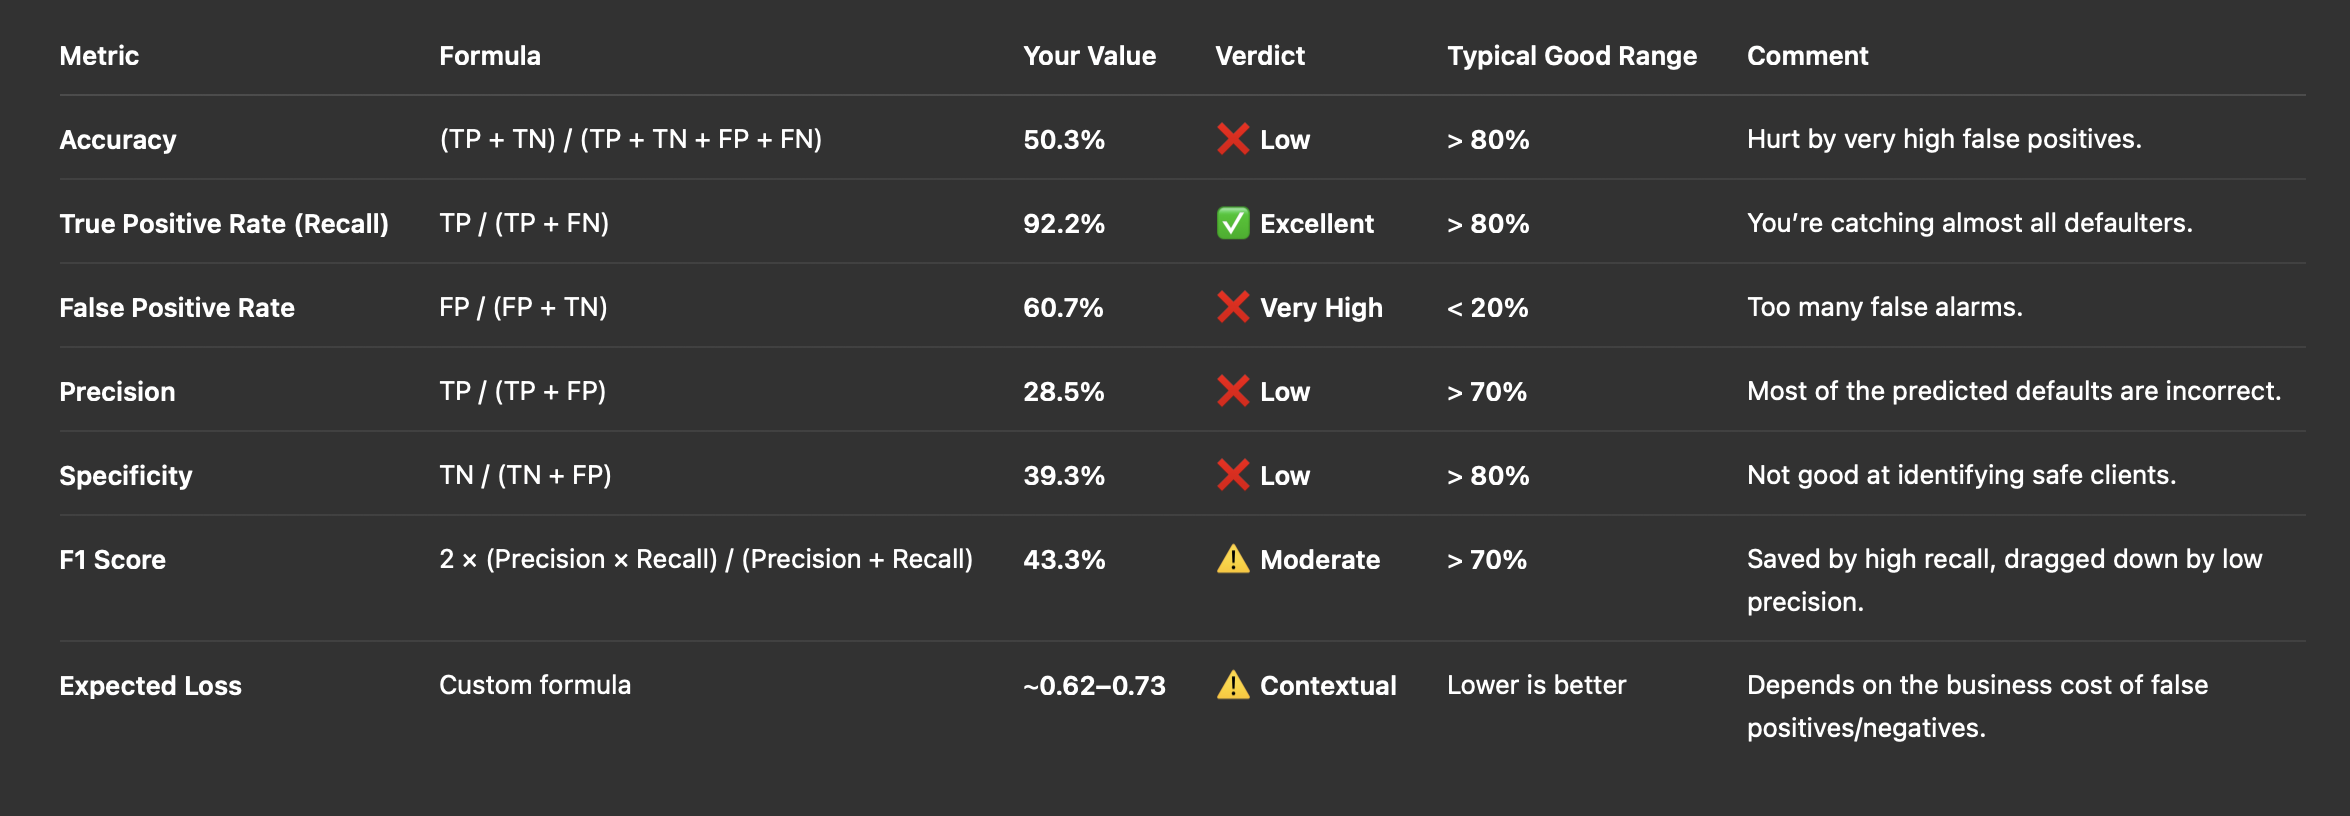

# PREDICTION WITH RANDOM FOREST

In [133]:
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("default~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 640x480 with 0 Axes>

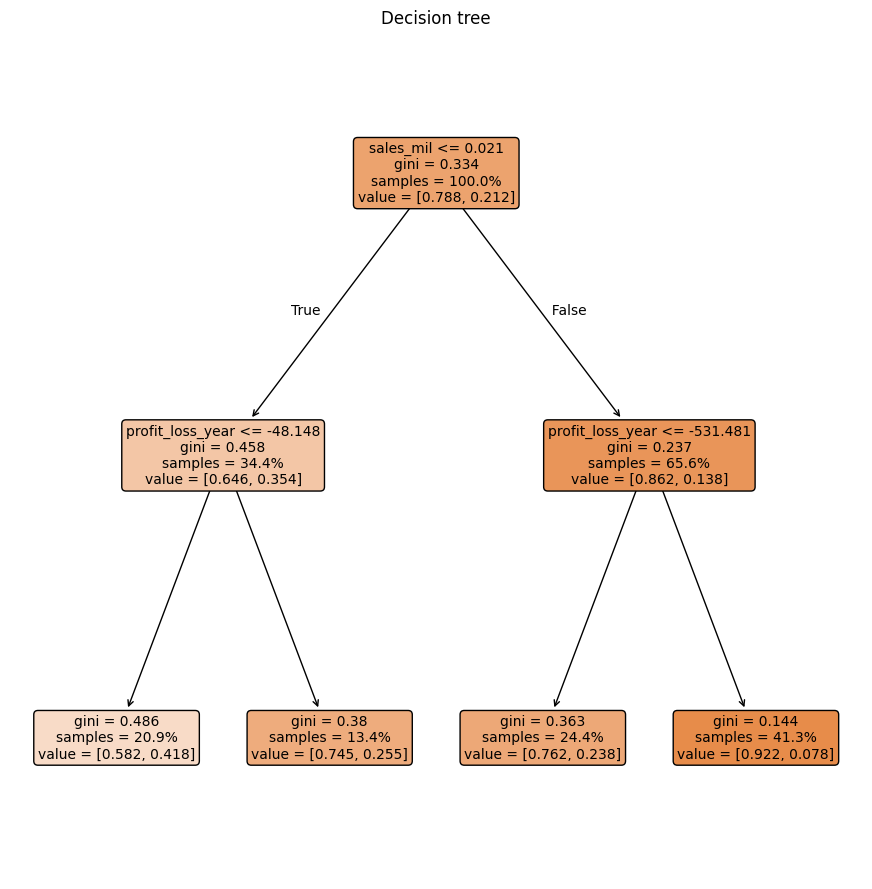

In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [135]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [136]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [137]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [138]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.813246,0.359209
1,5,16,0.813043,0.359330
2,6,11,0.812326,0.359307
3,6,16,0.813244,0.358997
4,7,11,0.812001,0.359345
5,7,16,0.812018,0.359283


Obtain optimal parameter values

In [139]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}

In [170]:
# Extract best parameters
best_params = prob_forest_fit.best_params_

# Find matching row in the DataFrame
best_index = prob_forest_cv_results[
    (prob_forest_cv_results["max_features"] == best_params["max_features"]) &
    (prob_forest_cv_results["min_samples_split"] == best_params["min_samples_split"])
].index[0]

print("Index of best parameters in CV table:", best_index)

Index of best parameters in CV table: 0


In [171]:
# Find the highest cv_auc and its index
max_cv_auc = prob_forest_cv_results["cv_auc"].max()
max_cv_auc_index = prob_forest_cv_results["cv_auc"].idxmax()

# Find the lowest cv_rmse and its index
min_cv_rmse = prob_forest_cv_results["cv_rmse"].min()
min_cv_rmse_index = prob_forest_cv_results["cv_rmse"].idxmin()

print(f"Highest cv_auc: {max_cv_auc} at index {max_cv_auc_index}")
print(f"Lowest cv_rmse: {min_cv_rmse} at index {min_cv_rmse_index}")

Highest cv_auc: 0.8132460877206829 at index 0
Lowest cv_rmse: 0.3589966875204658 at index 3


Get average (ie over the folds) RMSE and AUC

In [140]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [141]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.380953,0.741099
M2,19.0,0.373277,0.770109
M3,36.0,0.373752,0.773208
M4,80.0,0.370285,0.783264
M5,154.0,0.368106,0.787104
LASSO,79.0,0.366939,0.789463
RF,n.a.,0.359209,0.813246


Extract fold level RMSE and AUC

In [142]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [143]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.383924,0.376422,0.375728,0.371759,0.368950,0.369232,0.361038
1,0.374660,0.368917,0.369911,0.368697,0.362967,0.360199,0.352370
2,0.381761,0.373723,0.373585,0.368682,0.369655,0.370020,0.360159
3,0.381081,0.372352,0.374734,0.369332,0.368879,0.366430,0.360217
4,0.383342,0.374967,0.374800,0.372956,0.370077,0.368812,0.361123


In [144]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.731702,0.766133,0.770246,0.783904,0.788325,0.787063,0.807256
1,0.739073,0.764707,0.765067,0.771988,0.783509,0.788768,0.816847
2,0.744262,0.773798,0.781348,0.795088,0.790487,0.791163,0.817908
3,0.749433,0.779595,0.775405,0.786770,0.789411,0.795087,0.817581
4,0.741028,0.766313,0.773973,0.778567,0.783787,0.785234,0.806639


Now use loss function and search for best thresholds and expected loss over folds 

In [147]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [148]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [149]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.359,0.813,0.113,0.099,0.573,0.589


Create plots based on Fold5 in CV 

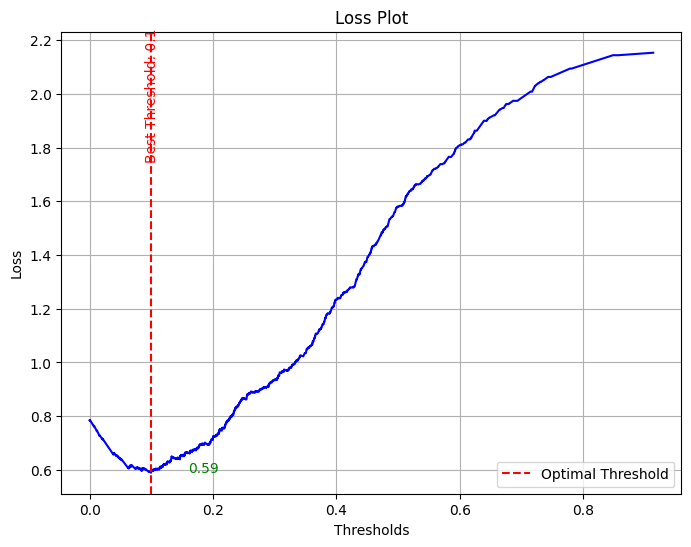

In [150]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

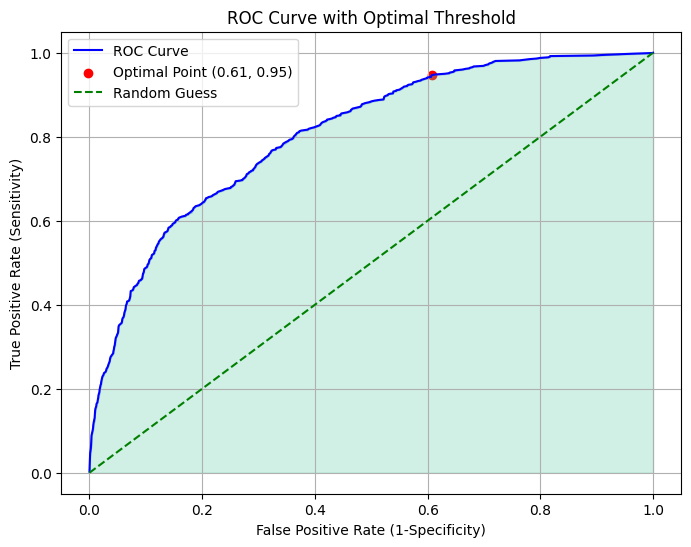

In [151]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [152]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


np.float64(0.356)

ROC AUC  on holdout

In [153]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


np.float64(0.81)

 Get expected loss on holdout

In [154]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


np.float64(0.592)

In [158]:
print(f"True Negatives (tn): {tn}")
print(f"False Positives (fp): {fp}")
print(f"False Negatives (fn): {fn}")
print(f"True Positives (tp): {tp}")

True Negatives (tn): 1348
False Positives (fp): 1822
False Negatives (fn): 54
True Positives (tp): 765


In [159]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Expected loss
FP_cost = 1
FN_cost = 10
expected_loss = (fp * FP_cost + fn * FN_cost) / (tp + tn + fp + fn)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"Expected Loss: {expected_loss:.3f}")

Accuracy: 0.530
Precision: 0.296
Recall (Sensitivity): 0.934
Specificity: 0.425
F1 Score: 0.449
Expected Loss: 0.592


## Final results

In [160]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [161]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.380953,0.741099,0.090909,0.733718
M2,19.0,0.373277,0.770109,0.090909,0.675235
M3,36.0,0.373752,0.773208,0.090909,0.667773
M4,80.0,0.370285,0.783264,0.090909,0.646399
M5,154.0,0.368106,0.787104,0.090909,0.636434
LASSO,79.0,0.366939,0.789463,0.090909,0.634240
RF,n.a.,0.359209,0.813246,0.113417,0.573122


In [ ]:
# Get X matrix and target variable from patsy
y_train, rfvars_train = patsy.dmatrices("default ~ " + "+".join(rfvars), data_train)

# Extract feature names here while rfvars_train is still a DesignMatrix
feature_names = rfvars_train.design_info.column_names

# Convert DesignMatrix to DataFrame for modeling (if not already done)
rfvars_train_df = pd.DataFrame(rfvars_train, columns=feature_names)

In [180]:
feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": prob_forest_fit_best.feature_importances_,
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

print(feature_importances)

                    Feature  Importance
0                  share_eq    0.076664
1                liq_assets    0.071607
2                 sales_mil    0.062740
3                     sales    0.062710
4          d1_sales_mil_log    0.061869
5              fixed_assets    0.060919
6               inc_bef_tax    0.059849
7               curr_assets    0.057787
8          profit_loss_year    0.056501
9              material_exp    0.050854
10                curr_liab    0.044704
11            personnel_exp    0.041623
12              inventories    0.038421
13                  ceo_age    0.035918
14                      age    0.027079
15                     age2    0.026670
16           subscribed_cap    0.025072
17            labor_avg_mod    0.024688
18      C(ind2_cat)[T.56.0]    0.012149
19        flag_miss_ceo_age    0.009149
20          balsheet_length    0.008773
21        extra_profit_loss    0.007560
22                   female    0.006970
23                      new    0.006892


In [181]:
print(len(feature_importances))

45


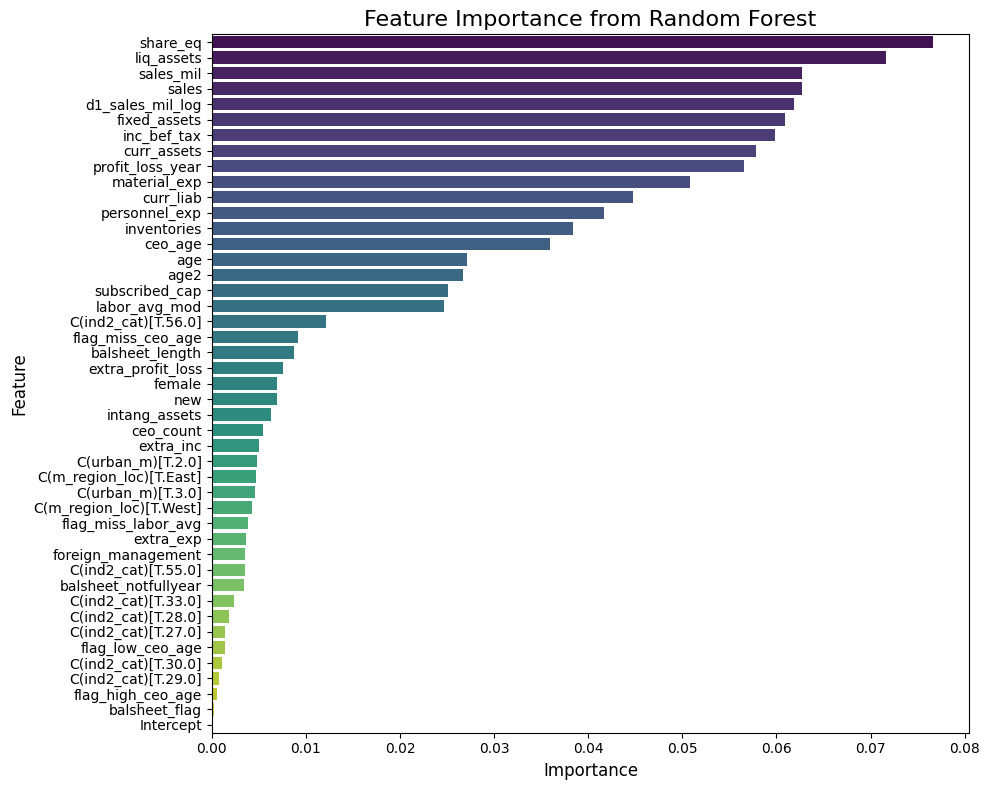

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot size
plt.figure(figsize=(10, 8))

# Create barplot
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importances,
    palette="viridis"
)

# Add labels and title
plt.title("Feature Importance from Random Forest", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()